# Classical CNN vs. MaxMin CNN

We compare the performance of two different networks, inspired from a baseline architecture:  
1. A Classical CNN consisting of Simple Convolution, Pooling and Fully Connected Layers.
2. A MaxMin CNN, where all the Convolution layers above are replaced with MaxMinConvolution Layers.

* Both the models have layers arranged as:  
``conv -> pool -> conv -> pool -> conv -> pool -> fully conn. -> fully conn. -> softmax`` (More about this later).  
* The arrangement of layers have been visualized after formation later in this notebook.


### Libraries Used:

The complete implementation has been done with **Keras** library of Python. Keras is a very flexible and extensible library built on top of **Theano** and **Tensorflow**. One does not need to have much familiarity with Keras API - the design is quite intuitive, with suitable comments included below. I have configured **Tensorflow as Keras backend** on my machine, the notebook executes without any errors, feel free to report an issue about problems related to Theano backend.


### Training Data:

We use the publicly available **CIFAR-10 dataset** to train the networks. Keras provides utilities to download and cache the dataset so nothing needs to be additionally downloaded beforehand.

* **Number of training examples: ** 50000
* **Number of validation examples: ** 10000
* **Number of classes: ** 10
* **Description: **
    * 10 mutually exclusive classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
    * (32 x 32) colored images with 3 channels (RGB). More information [here](https://www.cs.toronto.edu/~kriz/cifar.html).

-------------------------------------------------------------------

## Downloading dataset

The dataset will be downloaded and cached to **`~/.keras/datasets`**, or **`/tmp/.keras/datasets`**.  
**Caution: ** It downloads about 180 MB of data.

In [1]:
from keras.datasets import cifar10

# X_train and Y_train will be numpy arrays of length 50000.
# X_test  and Y_test  will be numpy arrays of length 10000.
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

print("Shape of X_train: %r ", X_train.shape)
print("Shape of Y_train: %r ", Y_train.shape)
print("Shape of X_test: %r ",  X_test.shape)
print("Shape of Y_test: %r ",  Y_test.shape)

Using TensorFlow backend.


('Shape of X_train: %r ', (50000, 32, 32, 3))
('Shape of Y_train: %r ', (50000, 1))
('Shape of X_test: %r ', (10000, 32, 32, 3))
('Shape of Y_test: %r ', (10000, 1))


### Displaying few images from the dataset

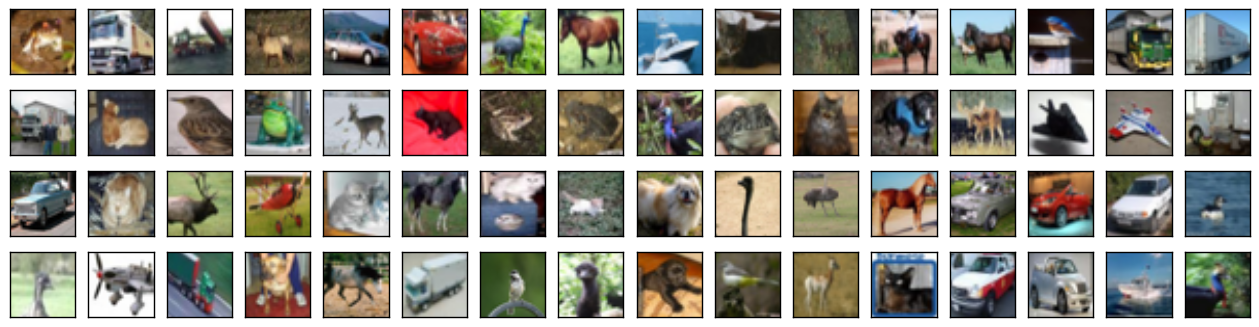

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Changing default figure size for properly accomodating images
from pylab import rcParams
rcParams['figure.figsize'] = (16, 4)

# Show first 64 training images
for i in range(64):
    # Choosing a subplot to plot an image
    plt.subplot(4, 16, i + 1)

    # We don't need 0, 5, 10, 15... ticks on axes for images, removing them
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(X_train[i])
plt.show()

## Setting up the Training Data

We'll do some preprocessing with the data for improving performance of the model. This involves artificial enlargement of dataset, by random flipping of images.

1. Cast X_train and X_test as **'float32'**.
2. All pixel intensities are in (0, 255), **scale down** to (0, 1).
3. One hot encoding of Y_train and Y_test. (For example `[3] => [ 0 0 0 1 0 0 0 0 0 0 ]`)
4. Randomly **flip** images horizontally.

In [3]:
### Global constants
####################

BATCH_SIZE = 32
NB_CLASSES = 10
NB_EPOCH = 25

# INPUT IMAGE DIMENSIONS
IMG_ROWS, IMG_COLS = 32, 32

In [4]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_train /= 255
X_test  /= 255

In [5]:
from keras.utils import np_utils

Y_train_onehot = np_utils.to_categorical(Y_train, NB_CLASSES)
Y_test_onehot  = np_utils.to_categorical(Y_test, NB_CLASSES)

print("Before onehot transformation, a label was: %r " % Y_train[0])
print("After  onehot transformation, a label is:  %r " % Y_train_onehot[0])

Before onehot transformation, a label was: array([6], dtype=uint8) 
After  onehot transformation, a label is:  array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]) 


### Using ImageDataGenerator of Keras

It is an infinite generator which "flows" data from ``X_train`` and ``Y_train`` till the training epochs end. It fetched batches from dataset and applies preprocessing accordingly - this includes random flipping.

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip=True       # randomly flip images
)

datagen.fit(X_train)

## Designing the Classical CNN

1. Three sets of ( Convolution + MaxPooling ) Layers with RelU activations.
2. Zero Padding added at every Convolution Layer - ensuring same dimensions after filter applications.
3. Fully Connected Layer at the end has Softmax activation.
4. All Convolution Layers have (5 x 5) filters with a stride of 1.
5. MaxPooling layer has (3 x 3) windows with a stride of 2, which means it has overlapping pooling.

This is quite similar to what was exercised in AlexNet (2012). The model is visualized after building.

In [7]:
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense

classical_cnn = Sequential([
    Convolution2D(32, 5, 5, activation='relu', border_mode='same', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Convolution2D(32, 5, 5, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Convolution2D(64, 5, 5, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(NB_CLASSES, activation='softmax'),
])

### Visualizing the Classical CNN

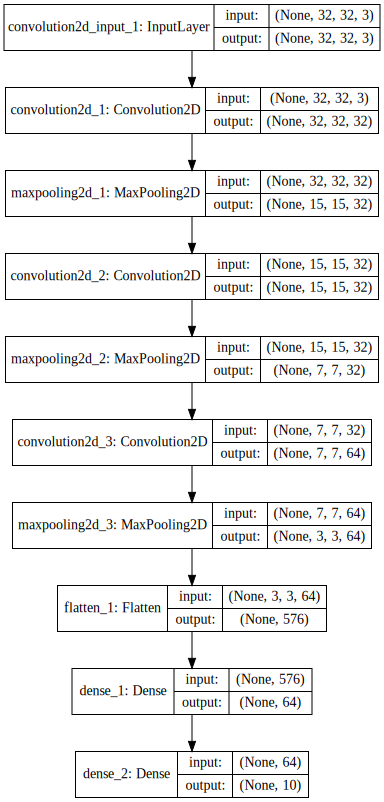

In [8]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(classical_cnn, show_shapes=True).create(prog='dot', format='svg'))

### Compiling the model

If you're unfamiliar with Keras, one needs to "compile" the model after its declaration. Here's where we set the target **Loss Function** and the **Optimizer** to use for Gradient Descent. The paper mentions usage of Stochastic Gradient Descent, but for the sake of faster convergence, we'll use the **Adam Optimizer**. Also for categorical targets, we'll use **Categorical Cross Entropy**. Both of these are pre implemented and provided by Keras.

* **Categorical Cross Entropy: **
$$C=−\frac{1}{n} \sum [y ln(\hat{y}) + (1 − y) ln(1 − \hat{y})]$$  
where $y$ and $\hat{y}$ would be one hot encoded vectors.  


* **Adam Optimizer: **  
If you haven't heard about Adam Optimizer, just treat it as a black box. It is an optimizer with a certain weight and bias rule just like simple Stochastic Gradient Descent. Here there are three additional parameters - $\beta_{1}$, $\beta_{2}$ and $\epsilon$. If they are not changed, Keras sets their default values as specified in the original paper: **0.9, 0.999 and 1e-8** respectively.

**Note**: [This paper](https://arxiv.org/abs/1412.6980) can be referred for more information on Adam, _although it is not required for further parts of this notebook._  

In [9]:
classical_cnn.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

In [10]:
# Fit the model - fit data flowing from generator for a specified number of epochs
classical_cnn_history = classical_cnn.fit_generator(
    datagen.flow(X_train, Y_train_onehot, batch_size=BATCH_SIZE),
    samples_per_epoch=X_train.shape[0],
    nb_epoch=NB_EPOCH,
    validation_data=(X_test, Y_test_onehot))

Epoch 01/30 - 141s - loss: 1.5626 - acc: 0.4222 - val_loss: 1.3307 - val_acc: 0.5200
Epoch 02/30 - 142s - loss: 1.2475 - acc: 0.5536 - val_loss: 1.2168 - val_acc: 0.5639
Epoch 03/30 - 142s - loss: 1.1058 - acc: 0.6092 - val_loss: 1.0735 - val_acc: 0.6206
Epoch 04/30 - 143s - loss: 1.0058 - acc: 0.6452 - val_loss: 0.9787 - val_acc: 0.6610
Epoch 05/30 - 146s - loss: 0.9438 - acc: 0.6676 - val_loss: 0.9529 - val_acc: 0.6665
Epoch 06/30 - 143s - loss: 0.8928 - acc: 0.6860 - val_loss: 0.9915 - val_acc: 0.6547
Epoch 07/30 - 143s - loss: 0.8587 - acc: 0.6985 - val_loss: 0.9004 - val_acc: 0.6840
Epoch 08/30 - 142s - loss: 0.8266 - acc: 0.7100 - val_loss: 0.9108 - val_acc: 0.6900
Epoch 09/30 - 143s - loss: 0.8035 - acc: 0.7191 - val_loss: 0.8584 - val_acc: 0.6985
Epoch 10/30 - 142s - loss: 0.7773 - acc: 0.7301 - val_loss: 0.8606 - val_acc: 0.7013
Epoch 11/30 - 143s - loss: 0.7544 - acc: 0.7346 - val_loss: 0.8787 - val_acc: 0.6986
Epoch 12/30 - 143s - loss: 0.7391 - acc: 0.7430 - val_loss: 0.827

## Designing the MaxMin CNN

All the Convolution Layers of Classical CNN are replaced by MaxMinConvolution2D Layers. The implementation of MaxMinConvolution2D layer class is kept separate in **`keras_maxmin_impl.py`** file alongwith this notebook.

A custom Keras Layer must implement three methods, refer to the docstrings in the script for more information.

In [11]:
from keras_maxmin_impl import MaxMinConvolution2D

maxmin_cnn = Sequential([
    MaxMinConvolution2D(32, 5, 5, activation='relu', border_mode='same', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    MaxMinConvolution2D(32, 5, 5, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    MaxMinConvolution2D(64, 5, 5, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(NB_CLASSES, activation='softmax'),
])

### Visualizing and Compiling the MaxMin CNN

These steps are similar to those performed above. Compilation of MaxMin CNN also includes the usage of **Adam Optimizer** to minimize **Categorical Cross Entropy** loss function.

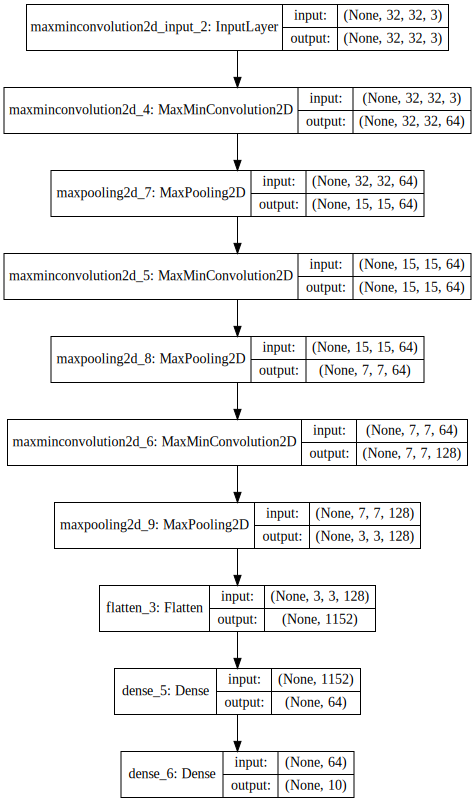

In [12]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(maxmin_cnn, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
maxmin_cnn.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])